# SST (Spatial Stress Test) Behavioral Analysis

Data Collected June 2015

In [1]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
import ipywidgets
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

v2


### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['navdir'] = op.join('/Volumes/group/awagner/sgagnon/SST/nav_data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['basedir'], 'data', 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['basedir'], 'data','shortcut_coords.csv')
dirs['order_file'] = op.join(dirs['basedir'], 'data','SST_env_order.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

v2


### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info.group.value_counts()

control    19
stress     17
Name: group, dtype: int64

In [5]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])
shortcut_coords

,env,x_lo,x_hi,y_lo,y_hi
0,env1,16,32,5,15
1,env2,8,28,28,48
2,env3,24,40,16,24
3,env4,16,32,16,24
4,env5,12,20,20,31
5,env6,24,40,24,40
6,env7,10,15,30,40
7,env8,16,32,0,16
8,env9,24,35,0,12
9,env10,48,56,24,40


In [6]:
trial_order = pd.read_csv(dirs['order_file'])
trial_order[['subid']] = trial_order[['subid']].astype(str)
trial_order.tail()

,subid,rep,run,trial,env
1399,50,2,11,2,12
1400,50,2,11,3,4
1401,50,2,12,1,2
1402,50,2,12,2,1
1403,50,2,12,3,6


## Read in/concatenate data files

#### Only need to run this if first time:

In [7]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = False
n_runs = 12

test_types = ['habit', 'shortcut']

# iterate through subjects
# for subid in subj_info.subid:
for subid in ['3']:
    print subid
    
    if test:
        d2 = pd.DataFrame() # dataframe of test files for a subj

        # iterate through environments
        for run_num in range(1, n_runs+1):

            # deal w/num -> str IDs
            if int(subid) < 10:
                sub_str = 'sst0'
            else:
                sub_str = 'sst'
                
            # add test file
            test_files = glob.glob(op.join(dirs['navdir'], sub_str + str(subid), 
                                           'run'+ str(run_num),
                                           'session_*', 'log.txt'))
            
            # get all files, including crashes where 2 files/run
            # note that grouping files into same run if a crash; 
            # this will be diff than for fmri data (where 2 sep runs)
            for i, test_file in enumerate(test_files):
                
                if i > 0: print '***** something happened, '+str(i+1)+' files for run ' +str(run_num)+'! *****'
                
                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)

                d1 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d1['subid'] = subid
                d1['run'] = run_num

                if run_num < 5:
                    d1['type'] = 'habit'
                else:
                    d1['type'] = 'shortcut'

                # force time to in seconds, relative to beginning of session
                d1.time = d1.time.astype(int)/1000
                
                if (run_num == 1) & (i == 0):
                    session_start = d1.time.min()                
                d1.time = d1.time - session_start

                # Append to subj's dataframe
                d2 = d2.append(d1, ignore_index=True)
                

        d2 = d2.loc[d2.command.isin(['VROBJECT_POS', 'VROBJECT_HEADING', 'INPUT_EVENT',
                                     'ORIENT', 'ARRIVED', 'ASSIGNED', 'NAVIGATE', 
                                     'SCAN', 'SHOCK'])]
        d2.drop(['c2', 'c5', 'c6', 'c7', 'c8'], axis=1, inplace=True) #unneeded cols

        # Any runs without 3 trials?
        counts = pd.groupby(d2.loc[d2.command == "ORIENT"], by=['subid', 'run']).count().reset_index()
        if counts[counts.command != 3].shape[0] > 0: print 'Don''t have 3 trials for a run!'

        # Get orient onsets, for trial parsing
        orient_onsets = d2[d2.command == "ORIENT"]

        orient_onsets['trial'] = 0 # init trial number

        for counter, ind in enumerate(orient_onsets.index):
            if counter == 0: # first trial
                first_ind = ind
                orient_onsets.loc[ind, 'trial'] = 1
                prev_ind = ind
            else:
                if orient_onsets.loc[ind, 'run'] == orient_onsets.loc[prev_ind, 'run']:
                    orient_onsets.loc[ind, 'trial'] = orient_onsets.loc[prev_ind, 'trial'] + 1
                    prev_ind = ind
                else:
                    orient_onsets.loc[ind, 'trial'] = 1
                    prev_ind = ind

        orient_onsets = orient_onsets.reset_index().merge(trial_order)

        d2['env'] = np.nan
        d2['rep'] = np.nan
        d2['trial'] = np.nan

        for i in orient_onsets.index:
            index_val = orient_onsets.loc[i, 'index']
            d2.loc[index_val, 'env'] = 'env' + orient_onsets.loc[i, 'env'].astype(str)
            d2.loc[index_val, 'rep'] = orient_onsets.loc[i, 'rep']
            d2.loc[index_val, 'trial'] = orient_onsets.loc[i, 'trial']

        d2.env.fillna(method='ffill', inplace=True)
        d2.rep.fillna(method='ffill', inplace=True)
        d2.trial.fillna(method='ffill', inplace=True)

        d2 = d2.loc[~d2.env.isnull()]

        print 'subj d2 shape:' + str(d2.shape)
        print len('env' + orient_onsets.env.astype(str))
        print len(d2.loc[orient_onsets['index'], 'env'])

        # Get 2D position in space
        dp = d2[d2.command == 'VROBJECT_POS'].reset_index()
        coordinates = pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist())[[2, 3, 4]]
        coordinates.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)

        dp = dp.join(coordinates)
        dp = dp.drop(['c4'], 1)
        dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
        dp.head()

        # Downsample
        dp['s'] = pd.to_datetime(dp.time, unit='s')
        dp = dp.resample('500L', on='s').first()
        dp.dropna(inplace=True)
        
        print 'subj dp (downsampled) shape:' + str(dp.shape)

        # Append to group data
        df = df.append(dp, ignore_index=True)
        print 'Group df shape: ' + str(df.shape)
        print '_______________________________________'

# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

3


/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sgagnon/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


subj d2 shape:(256507, 10)
36
36
subj dp (downsampled) shape:(4011, 14)
Group df shape: (4011, 14)
_______________________________________


#### Get item coordinates

In [ ]:
item_coordinates = pd.DataFrame()

dp = d2[d2.command == 'VROBJECT_POS'].reset_index()
coordinates = pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist())[[2, 3, 4]]
coordinates.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.join(coordinates)

for env in set(df_in.env):
    for item in proj['goals'][env].values():
        ditem = dp.loc[(dp.c3 == item) & (dp.command == 'VROBJECT_POS'), ['x', 'y']].reset_index()
        ditem = ditem.ix[0, ['x', 'y']] # get first entry
        ditem['item'] = item
        
        item_coordinates = item_coordinates.append(pd.DataFrame(ditem).T, ignore_index=True)
        
item_coordinates.to_csv('/Volumes/group/awagner/sgagnon/SST/nav_data/item_coordinates.csv')

## Look at data

#### Prune down the data (>13 million rows beforehand)

In [7]:
filename = '/Volumes/group/awagner/sgagnon/SST/nav_data/group_fmri_logs.h5'
df_in = pd.read_hdf(filename, 'df')
df_in.shape

(131569, 14)

### Plot

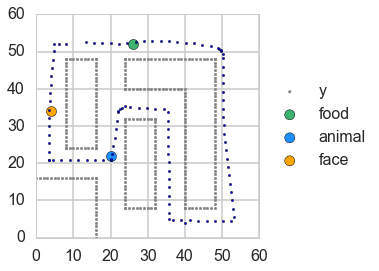

In [8]:
def plot_sub(subj, env, test_trial, rep):
    plot_paths(env=env, subj=subj, 
               dp=df_in.loc[(df_in['type'] == test_trial) &
                            (df_in.rep == rep)], 
               proj=proj, dirs=dirs)
    
subj_opts = ipywidgets.Select(options=list(df_in.subid.unique()))
env_opts = ipywidgets.ToggleButtons(options=list(np.sort(df_in.env.unique())))
test_opts = ipywidgets.ToggleButtons(options=list(['habit', 'shortcut']))
rep_opts = ipywidgets.IntSlider(min=1, max=2)

w = ipywidgets.interact(plot_sub, 
                        subj=subj_opts, 
                        env=env_opts, 
                        test_trial=test_opts, 
                        rep=rep_opts)